In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('homeworks/hw4/data_for_drivers_analysis.csv')

# Describe the dataset
print(data.describe())

# Check for missing values 
print(data.isnull().sum())

             brand            id  satisfaction        trust        build  \
count  2553.000000   2553.000000   2553.000000  2553.000000  2553.000000   
mean      4.857423   8931.480611      3.386604     0.549550     0.461810   
std       2.830096   5114.287849      1.172006     0.497636     0.498637   
min       1.000000     88.000000      1.000000     0.000000     0.000000   
25%       3.000000   4310.000000      3.000000     0.000000     0.000000   
50%       4.000000   8924.000000      4.000000     1.000000     0.000000   
75%       6.000000  13545.000000      4.000000     1.000000     1.000000   
max      10.000000  18088.000000      5.000000     1.000000     1.000000   

           differs         easy    appealing    rewarding      popular  \
count  2553.000000  2553.000000  2553.000000  2553.000000  2553.000000   
mean      0.334508     0.536232     0.451234     0.451234     0.536232   
std       0.471911     0.498783     0.497714     0.497714     0.498783   
min       0.000000 

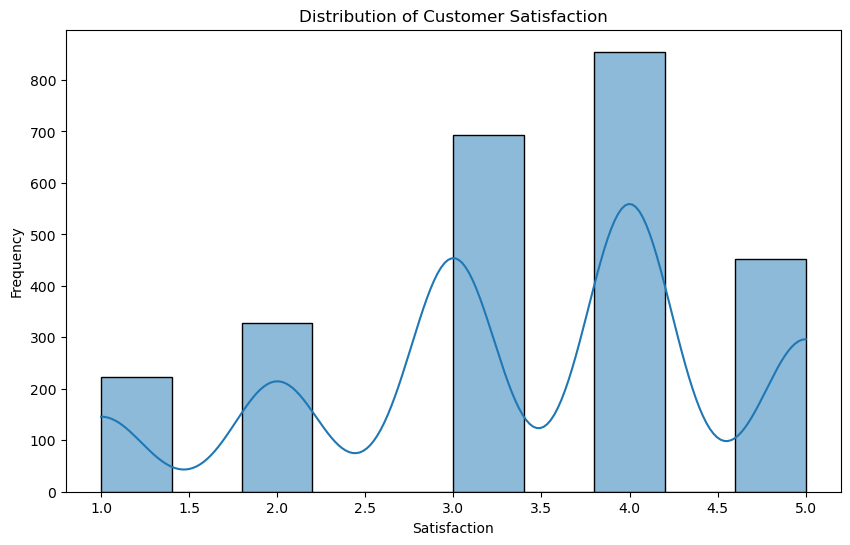

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['satisfaction'], kde=True, bins=10)
plt.title('Distribution of Customer Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Feature selection
features = ['trust', 'build', 'differs', 'easy', 'appealing', 'rewarding', 'popular', 'service', 'impact']
X = data[features]
y = data['satisfaction']

# Calculate Pearson correlations
correlations = data.corr()
pearson_corr = correlations['satisfaction'][features]

# Normalize the correlations
normalized_corr = (pearson_corr / pearson_corr.sum()) * 100
normalized_corr

trust        13.283356
build         9.968574
differs       9.600014
easy         11.064100
appealing    10.804975
rewarding    10.107052
popular       8.905177
service      13.044017
impact       13.222734
Name: satisfaction, dtype: float64

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Extract standardized regression coefficients (betas)
standardized_coefficients = model.coef_

normalized_coefficients = (np.abs(standardized_coefficients)/np.abs(standardized_coefficients).sum()) * 100
normalized_coefficients

array([25.28010899,  4.36346149,  6.08179763,  4.79820494,  7.38947857,
        1.10652591,  3.62885928, 19.30426892, 28.04729425])

In [ ]:
# Create a DataFrame for better visualization
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Standardized Coefficient': standardized_coefficients,
    'Normalized Coefficient': normalized_coefficients
})
coefficients_df

,Feature,Standardized Coefficient,Normalized Coefficient
0,trust,0.135635,25.280109
1,build,0.023411,4.363461
2,differs,0.032631,6.081798
3,easy,0.025744,4.798205
4,appealing,0.039647,7.389479
5,rewarding,0.005937,1.106526
6,popular,0.019470,3.628859
7,service,0.103573,19.304269
8,impact,0.150482,28.047294


In [ ]:
# Full model R-squared
full_r2 = model.score(X_scaled, y)

# Calculate usefulness (LMG values)
usefulness = []
for feature in range(X_scaled.shape[1]):
    X_temp = np.delete(X_scaled, feature, axis=1)
    temp_model = LinearRegression().fit(X_temp, y)
    temp_r2 = temp_model.score(X_temp, y)
    usefulness.append(full_r2 - temp_r2)

# Normalize the usefulness values
usefulness_normalized = (np.array(usefulness) / sum(usefulness)) * 100

# Create DataFrames for better visualization
usefulness_df = pd.DataFrame({
    'Feature': features,
    'Usefulness Value': usefulness_normalized
})

usefulness_df

,Feature,Usefulness Value
0,trust,31.517391
1,build,1.016743
2,differs,2.104285
3,easy,1.103478
4,appealing,2.713117
5,rewarding,0.060194
6,popular,0.780849
7,service,17.869775
8,impact,42.834168


In [ ]:
import shap

# Using the SHAP library's LinearExplainer for Shapley values approximation
explainer = shap.LinearExplainer(model, X_scaled)
shap_values = explainer.shap_values(X_scaled)

# Calculate mean absolute Shapley values for each feature and normalize
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
normalized_shap_values = (mean_abs_shap_values / mean_abs_shap_values.sum()) * 100

# Create a DataFrame for better visualization
shap_values_df = pd.DataFrame({
    'Feature': X.columns,
    'Shapley Value': mean_abs_shap_values,
    'Normalized Shapley Value': normalized_shap_values
})
shap_values_df

,Feature,Shapley Value,Normalized Shapley Value
0,trust,0.136576,26.694012
1,build,0.023157,4.526070
2,differs,0.028857,5.640139
3,easy,0.025924,5.066851
4,appealing,0.039060,7.634243
5,rewarding,0.005861,1.145452
6,popular,0.019465,3.804387
7,service,0.102030,19.941906
8,impact,0.130708,25.546941


In [ ]:
import random
import itertools
from sklearn.metrics import r2_score

# Prepare the features matrix X and the target vector y
X_matrix = X.values
y_vector = y.values

def approximate_shapley_values_manual(X, y, n_samples=1000):
    n_features = X.shape[1]
    shapley_values = np.zeros(n_features)
    random.seed(42)

    for i in range(n_features):
        feature_contributions = []
        
        for _ in range(n_samples):
            # Generate a random subset of features excluding the current feature
            subset = random.sample([x for x in range(n_features) if x != i], k=random.randint(0, n_features-1))
            subset_with_i = subset + [i]
            
            # Fit model with subset without the feature
            if subset:
                scaler_subset = StandardScaler()
                X_subset = scaler_subset.fit_transform(X[:, subset])
                model_subset = LinearRegression().fit(X_subset, y)
                r2_subset = r2_score(y, model_subset.predict(X_subset))
            else:
                r2_subset = 0  # baseline R² with no features
            
            # Fit model with subset with the feature
            scaler_subset_with_i = StandardScaler()
            X_subset_with_i = scaler_subset_with_i.fit_transform(X[:, subset_with_i])
            model_subset_with_i = LinearRegression().fit(X_subset_with_i, y)
            r2_subset_with_i = r2_score(y, model_subset_with_i.predict(X_subset_with_i))
            
            # Calculate marginal contribution
            marginal_contribution = r2_subset_with_i - r2_subset
            feature_contributions.append(marginal_contribution)
        
        # Calculate Shapley value for the feature
        shapley_values[i] = np.mean(feature_contributions)

    return shapley_values

# Calculate approximate Shapley values manually
shap_values_manual = approximate_shapley_values_manual(X_matrix, y_vector)

# Map the Shapley values to the feature names and normalize to sum to 100%
shapley_values_manual_df = pd.DataFrame({'Feature': X.columns, 'Shapley Value': shap_values_manual})
shapley_values_manual_df['Normalized Shapley Value'] = (shapley_values_manual_df['Shapley Value'] /
                                                          shapley_values_manual_df['Shapley Value'].sum()) * 100

shapley_values_manual_df

,Feature,Shapley Value,Normalized Shapley Value
0,trust,0.021209,19.547288
1,build,0.006640,6.119831
2,differs,0.006930,6.386692
3,easy,0.009254,8.528979
4,appealing,0.009916,9.139131
5,rewarding,0.007342,6.767128
6,popular,0.005680,5.234813
7,service,0.017968,16.560666
8,impact,0.023561,21.715472


In [ ]:
from relativeImp import relativeImp

yName = 'satisfaction'  # Specify the name of your outcome variable
xNames = ['trust', 'build', 'differs', 'easy', 'appealing', 'rewarding', 'popular', 'service', 'impact']  # List of predictor names

# Calculate Johnson's Relative Weights using relativeImp
relative_weights = relativeImp(data, outcomeName=yName, driverNames=xNames)
relative_weights

,driver,rawRelaImpt,normRelaImpt
0,trust,0.021623,19.835524
1,build,0.007217,6.620792
2,differs,0.007594,6.966081
3,easy,0.008982,8.239683
4,appealing,0.009099,8.346395
5,rewarding,0.006538,5.997431
6,popular,0.005878,5.392328
7,service,0.018134,16.635164
8,impact,0.023946,21.966601


In [ ]:
from relativeImp import relativeImp

yName = 'satisfaction'  # Specify the name of your outcome variable
# xNames = ['trust', 'build', 'differs', 'easy', 'appealing', 'rewarding', 'popular', 'service', 'impact']  # List of predictor names

# Calculate Johnson's Relative Weights using relativeImp
relative_weights = relativeImp(data, outcomeName=yName, driverNames=features)
relative_weights

,driver,rawRelaImpt,normRelaImpt
0,trust,0.021623,19.835524
1,build,0.007217,6.620792
2,differs,0.007594,6.966081
3,easy,0.008982,8.239683
4,appealing,0.009099,8.346395
5,rewarding,0.006538,5.997431
6,popular,0.005878,5.392328
7,service,0.018134,16.635164
8,impact,0.023946,21.966601


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Fit a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Calculate feature importances using the mean decrease in Gini coefficient
rf_feature_importances = rf_model.feature_importances_

# Normalize to sum to 100%
normalized_rf_feature_importances = (rf_feature_importances / rf_feature_importances.sum()) * 100

# Create a DataFrame for better visualization
rf_feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Decrease in Gini': rf_feature_importances,
    'Normalized Mean Decrease in Gini': normalized_rf_feature_importances
})

rf_feature_importances_df

,Feature,Mean Decrease in Gini,Normalized Mean Decrease in Gini
0,trust,0.155865,15.586537
1,build,0.102301,10.230144
2,differs,0.089897,8.989693
3,easy,0.099904,9.990365
4,appealing,0.085534,8.553448
5,rewarding,0.101057,10.105692
6,popular,0.094944,9.494376
7,service,0.129664,12.966365
8,impact,0.140834,14.083380


In [ ]:

import xgboost as xgb

# Fit an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)

# Get feature importances using the 'gain' metric
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Convert the importance dictionary to a DataFrame
xgb_importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# Normalize to sum to 100%
xgb_importance_df['Normalized Importance'] = (xgb_importance_df['Importance'] / xgb_importance_df['Importance'].sum()) * 100

xgb_importance_df

,Feature,Importance,Normalized Importance
0,trust,0.726525,28.986719
1,build,0.197839,7.893330
2,differs,0.141373,5.640452
3,easy,0.179203,7.149780
4,appealing,0.164887,6.578636
5,rewarding,0.163910,6.539633
6,popular,0.190827,7.613552
7,service,0.279030,11.132675
8,impact,0.462813,18.465223


In [ ]:
import random
import itertools
from sklearn.metrics import r2_score

# Prepare the features matrix X and the target vector y
X_matrix = X.values
y_vector = y.values

def approximate_shapley_values_manual(X, y, n_samples=1000):
    n_features = X.shape[1]
    shapley_values = np.zeros(n_features)
    random.seed(42)

    for i in range(n_features):
        feature_contributions = []
        
        for _ in range(n_samples):
            # Generate a random subset of features excluding the current feature
            subset = random.sample([x for x in range(n_features) if x != i], k=random.randint(0, n_features-1))
            subset_with_i = subset + [i]
            
            # Fit model with subset without the feature
            if subset:
                scaler_subset = StandardScaler()
                X_subset = scaler_subset.fit_transform(X[:, subset])
                model_subset = LinearRegression().fit(X_subset, y)
                r2_subset = r2_score(y, model_subset.predict(X_subset))
            else:
                r2_subset = 0  # baseline R² with no features
            
            # Fit model with subset with the feature
            scaler_subset_with_i = StandardScaler()
            X_subset_with_i = scaler_subset_with_i.fit_transform(X[:, subset_with_i])
            model_subset_with_i = LinearRegression().fit(X_subset_with_i, y)
            r2_subset_with_i = r2_score(y, model_subset_with_i.predict(X_subset_with_i))
            
            # Calculate marginal contribution
            marginal_contribution = r2_subset_with_i - r2_subset
            feature_contributions.append(marginal_contribution)
        
        # Calculate Shapley value for the feature
        shapley_values[i] = np.mean(feature_contributions)

    return shapley_values

# Calculate approximate Shapley values manually
shap_values_manual = approximate_shapley_values_manual(X_matrix, y_vector)

# Normalize the Shapley values to sum to 100%
normalized_shap_values_manual = (shap_values_manual / shap_values_manual.sum()) * 100

# Map the Shapley values to the feature names and normalize to sum to 100%
shapley_values_manual_df = pd.DataFrame({'Feature': X.columns, 'Shapley Value': shap_values_manual, 'Normalized Shapley Value': normalized_shap_values_manual})

shapley_values_manual_df

,Feature,Shapley Value,Normalized Shapley Value
0,trust,0.021209,19.547288
1,build,0.006640,6.119831
2,differs,0.006930,6.386692
3,easy,0.009254,8.528979
4,appealing,0.009916,9.139131
5,rewarding,0.007342,6.767128
6,popular,0.005680,5.234813
7,service,0.017968,16.560666
8,impact,0.023561,21.715472


In [ ]:
final_results = pd.DataFrame({
    'Feature': features,
    'Pearson Correlations': normalized_corr.values,
    'Standardized Regression Coefficient': normalized_coefficients,
    'Usefulness': usefulness_normalized,
    'Shapley Values': normalized_shap_values_manual,
    'Johnson\'s Weights': relative_weights['normRelaImpt'].values,
    'Mean Decrease in RF Gini Coefficient': normalized_rf_feature_importances, 
    'XGBoost Feature Importance': xgb_importance_df['Normalized Importance']
})

final_results

,Feature,Pearson Correlations,Standardized Regression Coefficient,Usefulness,Shapley Values,Johnson's Weights,Mean Decrease in RF Gini Coefficient,XGBoost Feature Importance
0,trust,13.283356,25.280109,31.517391,19.547288,19.835524,15.586537,28.986719
1,build,9.968574,4.363461,1.016743,6.119831,6.620792,10.230144,7.893330
2,differs,9.600014,6.081798,2.104285,6.386692,6.966081,8.989693,5.640452
3,easy,11.064100,4.798205,1.103478,8.528979,8.239683,9.990365,7.149780
4,appealing,10.804975,7.389479,2.713117,9.139131,8.346395,8.553448,6.578636
5,rewarding,10.107052,1.106526,0.060194,6.767128,5.997431,10.105692,6.539633
6,popular,8.905177,3.628859,0.780849,5.234813,5.392328,9.494376,7.613552
7,service,13.044017,19.304269,17.869775,16.560666,16.635164,12.966365,11.132675
8,impact,13.222734,28.047294,42.834168,21.715472,21.966601,14.083380,18.465223


In [ ]:
# Define a function to format the values
def format_percentage(value):
    return f"{value:.1f}%"

# Apply the formatting function to all relevant columns
for col in final_results.columns[1:]:
    final_results[col] = final_results[col].map(format_percentage)
final_results

,Feature,Pearson Correlations,Standardized Coefficient,Usefulness,Shapley Values,Johnson's Weights,Mean Decrease in RF Gini Coefficient,XGBoost Feature Importance
0,trust,13.3%,25.3%,31.5%,19.5%,19.8%,15.6%,29.0%
1,build,10.0%,4.4%,1.0%,6.1%,6.6%,10.2%,7.9%
2,differs,9.6%,6.1%,2.1%,6.4%,7.0%,9.0%,5.6%
3,easy,11.1%,4.8%,1.1%,8.5%,8.2%,10.0%,7.1%
4,appealing,10.8%,7.4%,2.7%,9.1%,8.3%,8.6%,6.6%
5,rewarding,10.1%,1.1%,0.1%,6.8%,6.0%,10.1%,6.5%
6,popular,8.9%,3.6%,0.8%,5.2%,5.4%,9.5%,7.6%
7,service,13.0%,19.3%,17.9%,16.6%,16.6%,13.0%,11.1%
8,impact,13.2%,28.0%,42.8%,21.7%,22.0%,14.1%,18.5%
